In [1]:
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
from scipy import fftpack
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm, tqdm_notebook
import math

from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from keras_tqdm import TQDMNotebookCallback
from tensorboard.plugins.hparams import api as hp
from livelossplot.tf_keras import PlotLossesCallback

import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave

from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
import timeit
from skimage.transform import resize
from timeit import default_timer as timer
from datetime import timedelta
import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.models import Model, load_model
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.utils import plot_model

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import bayes_mixed_glm as glm

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV

from spectrum import arburg, arma2psd
import pylab
from scipy.signal import find_peaks

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/pyparsing.py:3168: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, defaultdict


In [2]:
eeglab_path = '/home/raquib/Documents/MATLAB/eeglab2019_0/functions/'
octave.addpath(eeglab_path + 'guifunc')
octave.addpath(eeglab_path + 'popfunc')
octave.addpath(eeglab_path + 'adminfunc')
octave.addpath(eeglab_path + 'sigprocfunc')
octave.addpath(eeglab_path + 'miscfunc')

'.:/home/raquib/Documents/MATLAB/eeglab2019_0/functions/sigprocfunc:/home/raquib/Documents/MATLAB/eeglab2019_0/functions/adminfunc:/home/raquib/Documents/MATLAB/eeglab2019_0/functions/popfunc:/home/raquib/Documents/MATLAB/eeglab2019_0/functions/guifunc:/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/oct2py:/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/octave_kernel:/usr/lib/x86_64-linux-gnu/octave/4.2.2/site/oct/x86_64-pc-linux-gnu:/usr/lib/x86_64-linux-gnu/octave/site/oct/api-v51/x86_64-pc-linux-gnu:/usr/lib/x86_64-linux-gnu/octave/site/oct/x86_64-pc-linux-gnu:/usr/share/octave/4.2.2/site/m:/usr/share/octave/site/api-v51/m:/usr/share/octave/site/m:/usr/share/octave/site/m/startup:/usr/lib/x86_64-linux-gnu/octave/4.2.2/oct/x86_64-pc-linux-gnu:/usr/share/octave/4.2.2/m:/usr/share/octave/4.2.2/m/audio:/usr/share/octave/4.2.2/m/debian:/usr/share/octave/4.2.2/m/deprecated:/usr/share/octave/4.2.2/m/elfun:/usr/share/octave/4.2.2/m/general:/usr/share/octave/4.2

In [3]:
eegs = ['data/original/sub03/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub03/exp01/eeg/SP 110RMT r2/05-clean-prestimulus.set',
 'data/original/sub03/exp01/eeg/SP 110RMT r3/05-clean-prestimulus.set',
 'data/original/sub03/exp02/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub03/exp02/eeg/SP 110RMT r2/05-clean-prestimulus.set',
 'data/original/sub03/exp03/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub03/exp03/eeg/SP 110RMT r2/05-clean-prestimulus.set',
 'data/original/sub03/exp03/eeg/SP 110RMT r3/05-clean-prestimulus.set',
 'data/original/sub04/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub04/exp01/eeg/SP 110RMT r2/05-clean-prestimulus.set',
 'data/original/sub04/exp01/eeg/SP 110RMT r3/05-clean-prestimulus.set',
#  'data/original/sub05/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set', # NO MEP
#  'data/original/sub05/exp01/eeg/SP 110RMT r2/05-clean-prestimulus.set', # NO MEP
 'data/original/sub05/exp01/eeg/SP 110RMT r3/05-clean-prestimulus.set',
 'data/original/sub06/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub06/exp01/eeg/SP 110RMT r2/05-clean-prestimulus.set',
 'data/original/sub06/exp01/eeg/SP 110RMT r3/05-clean-prestimulus.set',
 'data/original/sub06/exp02/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub07/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub07/exp01/eeg/SP 110RMT r2/05-clean-prestimulus.set',
 'data/original/sub07/exp01/eeg/SP 110RMT r3/05-clean-prestimulus.set',
 'data/original/sub08/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub08/exp01/eeg/SP 110RMT r2/05-clean-prestimulus.set',
 'data/original/sub08/exp01/eeg/SP 110RMT r3/05-clean-prestimulus.set',
 'data/original/sub08/exp02/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub08/exp03/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub08/exp03/eeg/SP 110RMT r2/05-clean-prestimulus.set',
 'data/original/sub08/exp03/eeg/SP 110RMT r3/05-clean-prestimulus.set',
 'data/original/sub09/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub10/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub10/exp02/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub10/exp02/eeg/SP 110RMT r2/05-clean-prestimulus.set',
 'data/original/sub10/exp02/eeg/SP 110RMT r3/05-clean-prestimulus.set',
 'data/original/sub11/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub11/exp02/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub12/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub12/exp02/eeg/SP 110RMT r1/05-clean-prestimulus.set',
#  'data/original/sub13/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set', # LEFT HANDED
#  'data/original/sub14/exp01/eeg/SP 110RMT r2/05-clean-prestimulus.set', # BAD MEP
 'data/original/sub15/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub15/exp01/eeg/SP 110RMT r2/05-clean-prestimulus.set',
 'data/original/sub15/exp01/eeg/SP 110RMT r3/05-clean-prestimulus.set',
 'data/original/sub16/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub16/exp01/eeg/SP 110RMT r2/05-clean-prestimulus.set',
 'data/original/sub16/exp01/eeg/SP 110RMT r3/05-clean-prestimulus.set'
]

rejected_trials = [{'sub': 'sub005', 'exp': 'exp01', 'trial': 50},
    {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': 51},
    {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': 52},
    {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': 53},
    {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': 54},
    {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': 55},
    {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': 56},
    {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': 57},
    {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': 58},
    {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': 59},
    {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': 60},
    {'sub': 'sub08', 'exp': 'exp03', 'run': 'r1', 'trial': 0},
    {'sub': 'sub09', 'exp': 'exp01', 'run': 'r0', 'trial': 0},
    {'sub': 'sub11', 'exp': 'exp02', 'run': 'r0', 'trial': 14},
    {'sub': 'sub11', 'exp': 'exp02', 'run': 'r0', 'trial': 38},
    {'sub': 'sub12', 'exp': 'exp01', 'run': 'r0', 'trial': 0},
    {'sub': 'sub12', 'exp': 'exp02', 'run': 'r0', 'trial': 14},
    {'sub': 'sub12', 'exp': 'exp02', 'run': 'r0', 'trial': 36},
    {'sub': 'sub12', 'exp': 'exp02', 'run': 'r0', 'trial': 44}]

 # Read and process EEG

In [4]:
def read_eeg(path):
    eeg = octave.pop_loadset(path)
    new_trial_list = []
    for i in range(eeg.data.shape[2]):
        trial = eeg.data[:, :, i]
        time = np.linspace(-1000, 0, num=trial.shape[1])
        trial = pd.DataFrame(np.transpose(trial), columns=eeg.chanlocs.labels[0])
        trial['time'] = time
        new_trial_list.append(trial)
    return new_trial_list

def crop_trials(trial_list, duration_millis=500, sampling_rate=2048):
    new_trial_list = []
    for trial in trial_list:
        samples_to_pick = duration_millis * sampling_rate / 1000
        new_trial_list.append(trial.tail(int(samples_to_pick)))
    return new_trial_list, samples_to_pick

def crop_mep_region(mep_frame, crop_start=0.211, crop_end=0.4):
    multiplier = 7499 / 1.4998
    start = int(crop_start * multiplier)
    end = int(crop_end * multiplier)
    mep_cropped = mep_frame.iloc[start:end, :]
    time = mep_frame.iloc[start:end, :]
    return mep_cropped

def get_apb_column_name(mep_frame):
    if 'L APB' in mep_frame:
        return 'L APB'
    else:
        return 'APB'

def open_mep_as_df(path):
    fileMep = open(path, "r+")
    mep_frames = fileMep.read().split('\n\n')
    df_list = []
    for mep_frame in mep_frames:
        df_list.append(pd.read_csv(StringIO(mep_frame), '\t'))
    return df_list

def get_mep_path(eeg_path):
    segments = eeg_path.split('/')
    segments[4] = 'mep'
    segments = segments[:-1]
    mep_path = '/'.join(segments) + '/*.txt'
    mep_path = glob.glob(mep_path)[0]
    return mep_path

def calculate_mep_size(mep_frame):
    mep_cropped = crop_mep_region(mep_frame)
    apb_name = get_apb_column_name(mep_frame)
    max_row = mep_frame.iloc[mep_cropped.idxmax(axis=0)[apb_name]]
    min_row = mep_frame.iloc[mep_cropped.idxmin(axis=0)[apb_name]]
    mep_size = max_row[apb_name] - min_row[apb_name]
    return mep_size, min_row, max_row

# Read CMAP file.
def read_cmap(path):
    df = pd.read_excel(path, sheet_name='Raw data', header=None)
    columns = []
    ix = 0
    for r in df.index.values:
        if df[0][r] == 'Channel':
            ix = r
            break
    for c in df.columns.values:
        if (df[c][ix] == 2):
            columns.append(c)
    for r in df.index.values:
        if df[0][r] == 'Time (ms)':
            ix = r
            break
    df2 = df[columns].iloc[np.linspace(ix+1, df.shape[0]-2, df.shape[0]-ix-2)]
    df2['time'] = df[0].iloc[np.linspace(ix+1, df.shape[0]-2, df.shape[0]-ix-2)]
    return df2

# Identify CMAP peaks.
def find_cmap_peaks(df):
    df2 = df[(df['time'] > 105) * (df['time'] < 120)]
    time = df2['time']
    mean_clean = np.mean(df2.drop('time', axis=1), axis=1)
    return mean_clean.max(), mean_clean.min()

def get_cmap_path(eeg_path):
    segments = eeg_path.split('/')
    segments[4] = 'cmap'
    del segments[5]
    segments = segments[:-1]
    cmap_path = '/'.join(segments) + '/*.xlsx'
    cmap_paths = glob.glob(cmap_path)
    if (len(cmap_paths) == 0):
        print('No CMAP found for ' + cmap_path)
        return ''
    return cmap_paths[0]

def get_mep_category_absolute_binary(mep_size):
    if mep_size <= .5:
        return 0
    else:
        return 1
    
def calculate_mep_categories_binary(mep_sizes):
    p1 = np.percentile(mep_sizes, 50)
    cat = np.ones(len(mep_sizes)) * (mep_sizes >= p1)
    return cat

def calculate_mep_categories_cmap_binary(mep_sizes, cmap):
    sizes = []
    for mep_size in mep_sizes:
        sizes.append(mep_size / cmap)
    p1 = np.percentile(sizes, 50)
    cat = np.ones(len(mep_sizes)) * (sizes >= p1)
    return cat

def plot_freq_response(sig, time, title=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 3))
    ax1.plot(time/1000, sig)
    ax1.set(xlabel='Time (s)', ylabel="uV")
    ax1.set_title('Signal')
    
    fs = 1000/(time[1] - time[0])
    freq, fft = signal.welch(sig, fs, nperseg=4*fs)
    ax2.semilogy(freq, fft)
    ax2.set(xlabel='Frequency (Hz)', ylabel="Power")
    ax2.set_title('Welch PSD')
    
    fft = np.fft.fft(sig)
    freq = np.fft.fftfreq(len(sig), 1/fs)
    
    ax3.plot(freq, np.angle(fft))
    ax3.set(xlabel='Angle', ylabel="Power")
    ax3.set_title('Angle')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if title != None:
        plt.suptitle(title)
        
def blackman_harris(sig, time, numtaps, cutoff):
    fs = 1000 / (time[1] - time[0])
    x = np.concatenate((sig, np.ones(int(fs/2)) * sig[-1]))
    b = signal.firwin(numtaps, cutoff, window='blackmanharris', fs=fs)
    filtered = signal.lfilter(b, 1, x)
    delay = 0.5 * (numtaps - 1)
    filtered = filtered[numtaps-1:]
    filtered = filtered[0:int(len(filtered) - delay)]
    return filtered

In [5]:
def calculate_mep_latency_duration(mep_frame, plot=False, title=None):    
    
    # Calculate prestimulus mean amplitude and std.
    std_limit = 5
    peak_lookup_start_time = .215
    apb_name = get_apb_column_name(mep_frame)
    cropped = crop_mep_region(mep_frame, crop_start=0, crop_end=0.198)[apb_name]
    mean_amp = np.mean(cropped.values)
    std = np.std(cropped)
    
    # Find the index of the first point where amp > 5 SD of mean prestimulus
    df_peak = mep_frame[mep_frame['s'] > peak_lookup_start_time]
    peak_time = 0
    for idx, row in df_peak.iterrows():
        if (row[apb_name] > std_limit * std + mean_amp or row[apb_name] < mean_amp - std_limit * std):
            peak_time = row['s']
            break

    latency_absolute = mep_frame[mep_frame['s'] == peak_time]['s'].values[0]
    latency = (latency_absolute - 0.2)
    
    # Calculate the MEP duration.
    std_limit = 6
    sample_count = mep_frame[mep_frame['s'] < 0.03].shape[0]
    df_mean = crop_mep_region(mep_frame, crop_start=0.26, crop_end=0.3)[apb_name]
    mean_amp = np.mean(df_mean.values)
    std = np.std(df_mean.values)
    consecutive_baseline_count = 0
    return_to_baseline_time = 0
    cropped = crop_mep_region(mep_frame, crop_start=latency_absolute, crop_end=0.3)
    for idx, row in cropped.iterrows():
        if (row[apb_name] < mean_amp + std_limit * std) and (row[apb_name] > mean_amp - std_limit * std):
            if consecutive_baseline_count == 0:
                return_to_baseline_time = row['s']
            consecutive_baseline_count += 1
        else:
            consecutive_baseline_count = 0
        if consecutive_baseline_count > sample_count:
            break
    
    if plot == True:
        plt.figure(figsize=(20,5))
        plt.plot(mep_frame.iloc[0:2000]['s'], mep_frame.iloc[0:2000][apb_name])
        plt.axvspan(latency_absolute, return_to_baseline_time, color='r', alpha=0.15)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (mV)')
        if title != None:
            plt.title(title)
    return latency, return_to_baseline_time


# Inspect latencies.
# for eeg_path in eegs:
#     mep_list = open_mep_as_df(get_mep_path(eeg_path))
#     i = 0
#     for mep_frame in mep_list:
#         calculate_mep_latency(mep_frame, plot=True, title=eeg_path + ' - ' + str(i))
#         i = i+1
#         if i == 2:
#             break

In [6]:
def get_phase(channel, time, band, N=1023):
    filtered_band = blackman_harris(channel.values, time, N, [0.00001, band[0]])
    filtered_band = blackman_harris(filtered_band, time, N, band[1])
    time = time[-len(filtered_band):].values
    hilb = signal.hilbert(filtered_band)
    phase = np.angle(hilb, deg=True)
    phase_df = pd.DataFrame(phase, columns=['phase'])
    phase_df['time'] = time
    return phase_df[phase_df['time'] == 0]['phase'].values[0]

def get_power(channel, time, band, fs=500, crop_start_millis=-150):
    try:
        # Crop time
        channel = channel[time > crop_start_millis].values
        time = time[time > crop_start_millis].values

        # Resample
        ts = time[1] - time[0]
        secs = len(channel) * ts
        secs = secs/1000
        resampled = signal.resample(channel, int(secs*fs))
        resampled_time = np.linspace(time[0], time[-1], len(resampled))

        # PSD estimation
        m = resampled.min()
        if (m < 0):
            resampled = resampled - m
        ar, _, _ = arburg(resampled, 10)
        psd = arma2psd(ar, sides='centerdc')
        psd = psd/np.linspace(-250, 250, len(psd))
        psd = 10 * pylab.log10(psd/max(psd))
        df_power = pd.DataFrame(psd, columns=['psd'])
        df_power['freq'] = np.linspace(-250, 250, len(psd))

        # Average power across band
        return np.mean(df_power[(df_power['freq'] > band[0]) * (df_power['freq'] <= band[1])]['psd'].values)
    except ValueError as e:
        return np.nan


def hjorth_transform(trial):
    times = trial['time'].values
    potential = trial[(trial['time'] > -0.5) * (trial['time'] < -0.2)]
    hjorth = potential['C3'].values[0] - potential['FC1'].values[0] + potential['C3'].values[0] - potential['CP1'].values[0] + potential['C3'].values[0] - potential['FC5'].values[0] + potential['C3'].values[0] - potential['CP5'].values[0]
    trial = trial + hjorth
    trial['time'] = times
    # trial['ALL'] = trial.drop('time', axis=1).mean(axis=1).values
    trial['LTM1'] = trial[['FC5','FC1','C3','CP5','CP1','FC3','C5','C1','CP3']].mean(axis=1).values
    trial['RTM1'] = trial[['FC6','FC2','C4','CP6','CP2','FC4','C6','C2','CP4']].mean(axis=1).values
    trial['LTDLPFC'] = trial[['Fp1','AF3','AF7','F1','F3','F5','F7','FC1','FC3', 'FC5']].mean(axis=1).values
    trial['RTDLPFC'] = trial[['Fp2','AF4','AF8','F2','F4','F6','F8','FC2','FC4', 'FC6']].mean(axis=1).values
    trial['CNTRL'] = trial[['Fz','FCz','Cz','F1','FC1','C1','C2','FC2','F2']].mean(axis=1).values
    trial['LTOCC'] = trial[['PO7', 'PO5', 'PO3', 'O1']].mean(axis=1).values
    trial['RTOCC'] = trial[['PO4', 'PO6', 'PO8', 'O2']].mean(axis=1).values
    trial['OCC'] = trial[['PO7', 'PO5', 'PO3', 'POz', 'PO4', 'PO6', 'PO8', 'O1', 'Oz', 'O2']].mean(axis=1).values
    trial['LTPAR'] = trial[['P1', 'P3', 'CP1', 'CP3']].mean(axis=1).values
    trial['RTPAR'] = trial[['P2', 'P4', 'CP2', 'CP4']].mean(axis=1).values
    trial['PAR'] = trial[['P1', 'P3', 'CP1', 'CP3', 'P2', 'P4', 'CP2', 'CP4']].mean(axis=1).values
    return trial

def calculate_power_phase(trial):
    # Hjorth transform
    trial = hjorth_transform(trial)
    
    # Filter bands.
    N = 1023
    phase_power_dict = {}

    for channel in trial.drop(['time', 'RTM1', 'RTDLPFC', 'CNTRL', 'OCC', 'PAR'], axis=1).columns.values:
        phase_power_dict[channel + '_mu_phase'] = get_phase(trial[channel], trial['time'], [8, 12])
        phase_power_dict[channel + '_beta_phase'] = get_phase(trial[channel], trial['time'], [13, 30])
        phase_power_dict[channel + '_gamma_phase'] = get_phase(trial[channel], trial['time'], [30, 80])
        phase_power_dict[channel + '_low_beta_phase'] = get_phase(trial[channel], trial['time'], [12, 20])
        phase_power_dict[channel + '_high_beta_phase'] = get_phase(trial[channel], trial['time'], [20, 30])
        phase_power_dict[channel + '_low_gamma_phase'] = get_phase(trial[channel], trial['time'], [30, 46])
        phase_power_dict[channel + '_high_gamma_phase'] = get_phase(trial[channel], trial['time'], [46, 70])
        
        phase_power_dict[channel + '_mu_power'] = get_power(trial[channel], trial['time'], [8, 12])
        phase_power_dict[channel + '_beta_power'] = get_power(trial[channel], trial['time'], [13, 30])
        phase_power_dict[channel + '_gamma_power'] = get_power(trial[channel], trial['time'], [30, 80])
        phase_power_dict[channel + '_low_beta_power'] = get_power(trial[channel], trial['time'], [12, 20])
        phase_power_dict[channel + '_high_beta_power'] = get_power(trial[channel], trial['time'], [20, 30])
        phase_power_dict[channel + '_low_gamma_power'] = get_power(trial[channel], trial['time'], [30, 46])
        phase_power_dict[channel + '_high_gamma_power'] = get_power(trial[channel], trial['time'], [46, 70])
    return phase_power_dict
        
def process_trials(eeg_path):
    sub = eeg_path.split('/')[2]
    exp = eeg_path.split('/')[3]
    run = eeg_path.split('/')[5]
    
    trials = pickle.load(open(os.path.dirname(eeg_path) + "/05-clean-prestimulus.p", "rb"))

    # Calculate CMAP.
    cmap_max, cmap_min = find_cmap_peaks(read_cmap(get_cmap_path(eeg_path)))
    cmap = cmap_max - cmap_min

    # Calculate MEP categories.
    mep_list = open_mep_as_df(get_mep_path(eeg_path))
    mep_sizes = []
    for mep_df in mep_list:
        size, _, _ = calculate_mep_size(mep_df)
        mep_sizes.append(size)
    mep_cmap_list = calculate_mep_categories_cmap_binary(mep_sizes, cmap)
    mep_percentile_list = calculate_mep_categories_binary(mep_sizes)
    
    # Calculate powers and phases. And combine the results in a df list.
    power_phase_list = []
    for trial_num in range(len(trials)):
        trial = trials[trial_num]
    
        # Ignore rejected trials.
        break_loop = False
        for rejected in rejected_trials:
            if sub == rejected['sub'] and exp == rejected['exp'] and (rejected['trial'] == trial_num):
                break_loop = True
                break
        if break_loop:
            break
            
        # Calculate MEP latency and duration.
        latency, duration = calculate_mep_latency_duration(mep_list[trial_num])
        if duration == 0:
            continue
        
        # Calculate phase and power.
        print('Processing ' + sub + '/' + exp + '/' + run + '/' + str(trial_num))
        try:
            power = calculate_power_phase(trial)
        except ValueError as e:
            print('Skipping ' + sub + '/' + exp + '/' + run + '/' + str(trial_num) + ': ' + str(e))
            continue

        power_phase_dict = power
        power_phase_dict['sub'] = sub
        power_phase_dict['exp'] = exp
        power_phase_dict['run'] = run
        power_phase_dict['trial_num'] = trial_num
        power_phase_dict['cmap'] = cmap
        power_phase_dict['mep_size'] = mep_sizes[trial_num]
        power_phase_dict['mep_cat_abs'] = get_mep_category_absolute_binary(mep_sizes[trial_num])
        power_phase_dict['mep_cat_percentile'] = mep_percentile_list[trial_num]
        power_phase_dict['mep_cat_cmap'] = mep_cmap_list[trial_num]
        power_phase_dict['mep_by_cmap'] = mep_sizes[trial_num] / cmap
        power_phase_dict['mep_latency'] = latency
        power_phase_dict['mep_duration'] = duration        
        power_phase_list.append(power_phase_dict)
    return power_phase_list

# Read excel

In [87]:
df_power = pd.read_excel('114-phase-powers-v1.xlsx')

In [88]:
df_power['mep_by_cmap_log'] = np.log(df_power['mep_by_cmap'])

In [89]:
df_power.shape

(1726, 994)

In [90]:
df_power.to_excel('116-lmm-v1.xlsx')

In [94]:
channel = 'LTM1'
band = 'mu'
df_power2 = df_power[((df_power[channel + '_'+band+'_phase'] + 180 >= 45) & (df_power[channel + '_'+band+'_phase'] + 180 <= 135) | ((df_power[channel + '_'+band+'_phase'] + 180 >= 225) & (df_power[channel + '_'+band+'_phase'] + 180 > 315)))]
df_power2[channel + '_'+band+'_phase_cat'] = df_power2[channel + '_'+band+'_phase'].apply(lambda x: 0 if x < 135 else 1)
df_power2.to_excel('116-lmm-v1.xlsx')

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


# Interaction plot

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Troughs')

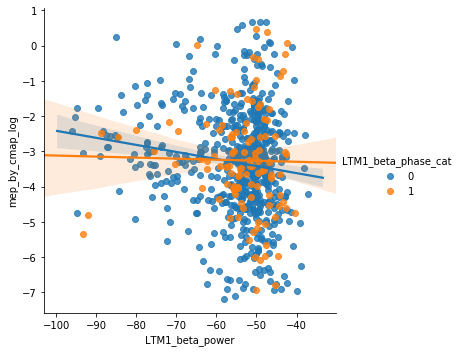

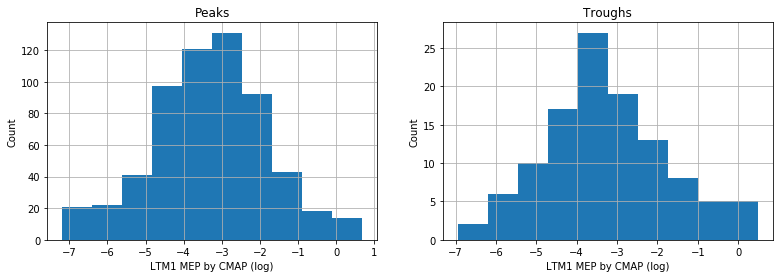

In [86]:
channel = 'LTM1'
band = 'beta'
df_power2 = df_power[((df_power[channel + '_'+band+'_phase'] + 180 >= 45) & (df_power[channel + '_'+band+'_phase'] + 180 <= 135) | ((df_power[channel + '_'+band+'_phase'] + 180 >= 225) & (df_power[channel + '_'+band+'_phase'] + 180 > 315)))]
df_power2[channel + '_'+band+'_phase_cat'] = df_power2[channel + '_'+band+'_phase'].apply(lambda x: 0 if x < 135 else 1)

sns.lmplot(x=channel + '_' + band + '_power', y="mep_by_cmap_log", hue=channel + '_'+band+'_phase_cat', data=df_power2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))
df_power2[df_power2[channel + '_'+band+'_phase_cat'] == 0]['mep_by_cmap_log'].hist(ax=ax1)
ax1.set_xlabel(channel + ' MEP by CMAP (log)')
ax1.set_ylabel('Count')
ax1.set_title('Peaks')

df_power2[df_power2[channel + '_'+band+'_phase_cat'] == 1]['mep_by_cmap_log'].hist(ax=ax2)
ax2.set_xlabel(channel + ' MEP by CMAP (log)')
ax2.set_ylabel('Count')
ax2.set_title('Troughs')